# Dados do Setor de Saúde

Este notebook tem como objetivo analisar os indicadores mais importantes ou principais sobre o setor de saúde suplementar, sendo eles principalmente: sinistralidade, taxa de cobertura, número de operadores e VCHM.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import src.demonstracoes_contabeis as dc

# options
pd.options.display.float_format = '{:.2f}'.format

## Sinistralidade

Segundo informações divulgada pela ANS, o cálculo da SINISTRALIDADE deve seguir a seguinte fórmula:

<br>

$$
Sinistralidade = \frac{\text{Eventos Indenizáveis Líquidos} + |CCT|}{\text{Receitas com Operações de Assistência a Saúde} + |CCT|}
$$

<br>

Essas informações nos demonstrativos contábeis correspondem aos códigos:

- Eventos Indenizáveis Líquidos - 41
- Receitas com Operações de Assistência a Saúde - 31
- Contraprestações de Corresponsabilidade Cedida (CCT) - 3117, 31171

In [2]:
data = dc.download_data(start_year=2013, end_year=2023)
data = data.drop(['DESCRICAO', 'VL_SALDO_INICIAL'], axis=1)

data.info()

/home/ian/Code/ipcap-hapvida/src/demonstracoes_contabeis.py:39: DtypeWarning: Columns (0,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f, sep=';', encoding='latin1', on_bad_lines='skip') for f in all_csv_files), ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27065107 entries, 0 to 27065106
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DATA               object 
 1   REG_ANS            float64
 2   CD_CONTA_CONTABIL  float64
 3   VL_SALDO_FINAL     object 
 4   DT_CARGA           object 
dtypes: float64(2), object(3)
memory usage: 1.0+ GB


In [3]:
# seleciona somente as linhas relevantes do demonstrativo contabil e aplica módulo
ans_contabil = data.loc[data['CD_CONTA_CONTABIL'].isin([3117, 31171, 41, 311])].copy()

ans_contabil['VL_SALDO_FINAL'] = ans_contabil['VL_SALDO_FINAL'].apply(lambda x: float(x.replace(',', '.')))
ans_contabil['VL_SALDO_FINAL'] = np.where(ans_contabil['CD_CONTA_CONTABIL'].isin([3117, 31171]), ans_contabil['VL_SALDO_FINAL'].abs(), ans_contabil['VL_SALDO_FINAL'])

ans_contabil.sample(10).reset_index(drop=True)

,DATA,REG_ANS,CD_CONTA_CONTABIL,VL_SALDO_FINAL,DT_CARGA
0,2022-10-01,321931.00,311.00,24218674.25,NaN
1,01/07/2021,352519.00,41.00,15766506.86,NaN
2,01/01/2020,349682.00,311.00,47919538.57,NaN
3,01/01/2020,354783.00,3117.00,1411553.87,NaN
4,01/01/2021,422134.00,311.00,0.00,NaN
5,01/10/2020,351776.00,41.00,22677877.73,NaN
6,01/01/2017,416495.00,41.00,5191642.98,NaN
7,01/04/2019,420093.00,41.00,1331899.37,NaN
8,01/10/2020,312851.00,3117.00,52200753.10,NaN
9,01/07/2014,385620.00,31171.00,718.64,NaN


In [4]:
# limpeza das datas no banco de dados
def parse_dates(str_date: str):
    for format in ('%Y-%m-%d', '%Y/%m/%d', '%d/%m/%Y'):
        try:
            return pd.to_datetime(str_date, format=format)
        except ValueError:
            continue
    return pd.NaT

ans_contabil['DATA'] = ans_contabil['DATA'].apply(parse_dates)

months = ans_contabil['DATA'].dt.month
years = ans_contabil['DATA'].dt.year

cond = [months == 1, months == 4, months == 7, months == 10]
labels = ['1T' + years.astype(str), '2T' + years.astype(str), '3T' + years.astype(str), '4T' + years.astype(str)]

ans_contabil['TRIMESTRE'] = np.select(cond, labels, default=None)
ans_contabil['DATA'] = ans_contabil['DATA'].dt.year

ans_contabil = ans_contabil.rename(columns={'DATA': 'ANO'})

ans_contabil.sample(10).reset_index(drop=True)

,ANO,REG_ANS,CD_CONTA_CONTABIL,VL_SALDO_FINAL,DT_CARGA,TRIMESTRE
0,2021,321044.00,3117.00,15672005.70,NaN,1T2021
1,2018,311294.00,31171.00,693065.59,NaN,2T2018
2,2021,305227.00,41.00,29621372.64,NaN,2T2021
3,2021,416401.00,311.00,61509376.24,NaN,3T2021
4,2020,323055.00,31171.00,2433633.74,NaN,2T2020
5,2013,364312.00,311.00,116207857.98,NaN,3T2013
6,2015,379956.00,311.00,267365296.25,NaN,2T2015
7,2013,320862.00,311.00,27700348.37,NaN,3T2013
8,2020,364312.00,41.00,64274523.47,NaN,1T2020
9,2021,407224.00,311.00,2306124.89,NaN,2T2021


In [5]:
# pivot
ans_pivot = ans_contabil.pivot_table(index=['ANO', 'TRIMESTRE'], columns='CD_CONTA_CONTABIL', values='VL_SALDO_FINAL', aggfunc='sum').reset_index()

ans_pivot[3117] = ans_pivot[3117] + ans_pivot[31171]
ans_pivot = ans_pivot.drop(31171, axis=1)

ans_pivot = ans_pivot.rename(columns={3117: 'CCT', 311: 'RECEITAS', 41: 'DESPESAS'})
ans_pivot.columns.name = None

ans_pivot.head(10)

,ANO,TRIMESTRE,DESPESAS,RECEITAS,CCT
0,2013,1T2013,20562842033.53,26074051935.48,399235902.48
1,2013,2T2013,41621047194.42,51147940625.90,790183617.28
2,2013,3T2013,66314842085.29,79661190080.13,1202326789.42
3,2013,4T2013,90925302327.91,109129768746.06,2149971353.68
4,2014,1T2014,24221829497.70,30309092045.47,812313769.41
5,2014,2T2014,50619016419.62,61465867227.62,1589046443.51
6,2014,3T2014,78947913960.35,94513929142.47,2089950017.69
7,2014,4T2014,106476621883.16,127740637574.28,2522511274.07
8,2015,1T2015,27748857260.78,34740478406.58,445423407.98
9,2015,2T2015,57862622524.96,70258319724.58,906090292.99


In [6]:
ans_pivot['SINISTRALIDADE'] = (ans_pivot['DESPESAS'] + ans_pivot['CCT']) / (ans_pivot['RECEITAS'] + ans_pivot['CCT'])

ans_pivot['SINISTRALIDADE'].describe().loc[['mean', 'std', 'min', 'max']]

mean   0.83
std    0.03
min    0.74
max    0.88
Name: SINISTRALIDADE, dtype: float64

In [7]:
ans_pivot['SINISTRALIDADE'].where(ans_pivot['TRIMESTRE'] == '2T2023').dropna()

41   0.86
Name: SINISTRALIDADE, dtype: float64

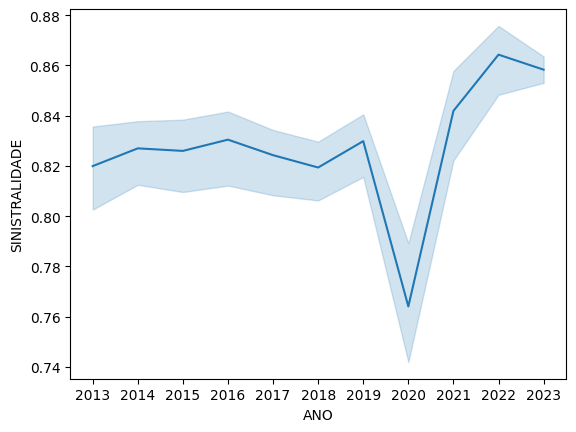

In [8]:
ans_pivot['ANO'] = ans_pivot['ANO'].astype(int)

plot = sns.lineplot(data=ans_pivot, x='ANO', y='SINISTRALIDADE')
plot.set_xticks(ans_pivot['ANO'].unique());


In [9]:
# regressão linear
X = ans_pivot['ANO'].values.reshape(-1, 1)
y = ans_pivot['SINISTRALIDADE'].values.reshape(-1, 1)

lm = LinearRegression()
lm.fit(X, y)

print(lm.intercept_)
print(lm.coef_)


[-2.95778729]
[[0.0018754]]


In [10]:
sinistralidade_inicial = ans_pivot['SINISTRALIDADE'].loc[ans_pivot['ANO'] == 2013].mean()
taxa_crescimento_percentual = (lm.coef_[0][0] / sinistralidade_inicial) * 100

print("Taxa de Crescimento Anual: ", round(taxa_crescimento_percentual, 2))

Taxa de Crescimento Anual:  0.23


## Taxa de Cobertura

In [6]:
data = pd.concat([pd.read_csv(f'data/num/{file}', dtype={'#ID_CMPT_MOVEL': 'category', 'QT_BENEFICIARIO_ATIVO': np.int32, 'COBERTURA_ASSIST_PLAN': np.int32}) for file in os.listdir('data/num/')], ignore_index=True)

grouped_data = data.groupby(['#ID_CMPT_MOVEL'])['QT_BENEFICIARIO_ATIVO'].sum().reset_index()

grouped_data

,#ID_CMPT_MOVEL,QT_BENEFICIARIO_ATIVO
0,201412,43653
1,201512,89461
2,201612,211128
3,201712,137596
4,201812,105994
5,201912,80422
6,202012,59724
7,202112,55674
8,202212,49296


In [3]:
data = pd.read_csv('data/num/202212.csv', dtype={'#ID_CMPT_MOVEL': 'category', 'QT_BENEFICIARIO_ATIVO': np.int32, 'COBERTURA_ASSIST_PLAN': np.int32})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16244393 entries, 0 to 16244392
Data columns (total 3 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   #ID_CMPT_MOVEL         category
 1   COBERTURA_ASSIST_PLAN  int32   
 2   QT_BENEFICIARIO_ATIVO  int32   
dtypes: category(1), int32(2)
memory usage: 139.4 MB
